# Download Data (platform: neptune.ml)

In [1]:
!mkdir -p ./data/fashion

In [2]:
!curl http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -o ./data/fashion/train-labels-idx1-ubyte.gz
!curl http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -o ./data/fashion/t10k-images-idx3-ubyte.gz
!curl http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -o ./data/fashion/t10k-labels-idx1-ubyte.gz
!curl http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -o ./data/fashion/train-images-idx3-ubyte.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29515  100 29515    0     0   130k      0 --:--:-- --:--:-- --:--:--  131k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4318k  100 4318k    0     0  3330k      0  0:00:01  0:00:01 --:--:-- 3332k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5148  100  5148    0     0  63833      0 --:--:-- --:--:-- --:--:-- 64350
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.1M  100 25.1M    0     0  24.1M      0  0:00:01  0:00:01 --:--:-- 24.1M


# Import Packages

In [3]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import tensorflow  as tf
from keras.layers import *
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


# Set Configs

In [4]:
batch_size = 128
num_classes = 10
epochs = 40
w_l2 = 1e-5

In [5]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

# Load Data

In [6]:
# https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [7]:
x_train, y_train =load_mnist('./data/fashion', kind='train')
x_test, y_test = load_mnist('./data/fashion', kind='t10k')

In [8]:
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Experiment1: Swish (He initialization)

In [ ]:
# , kernel_initializer='he_normal'

In [9]:
def swish(x):
    return x * K.sigmoid(x)
    #return x * (1/(1 + K.exp(-x)))

In [25]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(swish))
model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(w_l2), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(swish))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(swish))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_13 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
activation_13 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_14 (Batc (None, 24, 24, 64)        256       
_________________________________________________________________
activation_14 (Activation)   (None, 24, 24, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
__________

In [26]:
hist_swish=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 17s - loss: 0.4179 - acc: 0.8583 - val_loss: 0.3225 - val_acc: 0.8868
Epoch 2/40
60000/60000 [==============================] - 16s - loss: 0.2882 - acc: 0.9006 - val_loss: 0.2692 - val_acc: 0.9038
Epoch 3/40
60000/60000 [==============================] - 16s - loss: 0.2493 - acc: 0.9129 - val_loss: 0.2721 - val_acc: 0.9077
Epoch 4/40
60000/60000 [==============================] - 16s - loss: 0.2247 - acc: 0.9229 - val_loss: 0.2564 - val_acc: 0.9123
Epoch 5/40
60000/60000 [==============================] - 16s - loss: 0.2069 - acc: 0.9299 - val_loss: 0.2579 - val_acc: 0.9165
Epoch 6/40
60000/60000 [==============================] - 16s - loss: 0.1929 - acc: 0.9362 - val_loss: 0.2552 - val_acc: 0.9188
Epoch 7/40
60000/60000 [==============================] - 16s - loss: 0.1801 - acc: 0.9418 - val_loss: 0.2831 - val_acc: 0.9100
Epoch 8/40
60000/60000 [==============================

## Experiment 2: scaled swish

https://www.reddit.com/r/MachineLearning/comments/773epu/r_swish_a_selfgated_activation_function_google/?st=j90z3vt1&sh=5c4ffad8

In [33]:
def swish_rev(x):
    return 1.67653251702 * (x * K.sigmoid(x))

In [34]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(swish_rev))
model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(w_l2), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(swish_rev))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(swish_rev))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [35]:
hist_swish_rev=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 17s - loss: 0.4324 - acc: 0.8524 - val_loss: 0.2941 - val_acc: 0.8961
Epoch 2/40
60000/60000 [==============================] - 17s - loss: 0.2858 - acc: 0.9000 - val_loss: 0.2730 - val_acc: 0.9001
Epoch 3/40
60000/60000 [==============================] - 17s - loss: 0.2467 - acc: 0.9132 - val_loss: 0.2465 - val_acc: 0.9129
Epoch 4/40
60000/60000 [==============================] - 17s - loss: 0.2204 - acc: 0.9225 - val_loss: 0.2569 - val_acc: 0.9135
Epoch 5/40
60000/60000 [==============================] - 17s - loss: 0.2020 - acc: 0.9306 - val_loss: 0.2518 - val_acc: 0.9153
Epoch 6/40
60000/60000 [==============================] - 17s - loss: 0.1846 - acc: 0.9378 - val_loss: 0.2368 - val_acc: 0.9242
Epoch 7/40
60000/60000 [==============================] - 17s - loss: 0.1751 - acc: 0.9421 - val_loss: 0.2511 - val_acc: 0.9223
Epoch 8/40
60000/60000 [==============================

## Experiment 3: ReLU

In [36]:
# input image dimensions
img_rows, img_cols = 28, 28

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),  kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3),  kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [37]:
hist_relu=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 16s - loss: 0.4398 - acc: 0.8477 - val_loss: 0.5225 - val_acc: 0.8367
Epoch 2/40
60000/60000 [==============================] - 15s - loss: 0.2994 - acc: 0.8951 - val_loss: 0.2812 - val_acc: 0.8968
Epoch 3/40
60000/60000 [==============================] - 15s - loss: 0.2625 - acc: 0.9095 - val_loss: 0.2641 - val_acc: 0.9104
Epoch 4/40
60000/60000 [==============================] - 15s - loss: 0.2377 - acc: 0.9182 - val_loss: 0.2520 - val_acc: 0.9119
Epoch 5/40
60000/60000 [==============================] - 15s - loss: 0.2181 - acc: 0.9260 - val_loss: 0.2734 - val_acc: 0.9058
Epoch 6/40
60000/60000 [==============================] - 15s - loss: 0.2063 - acc: 0.9321 - val_loss: 0.2439 - val_acc: 0.9183
Epoch 7/40
60000/60000 [==============================] - 15s - loss: 0.1930 - acc: 0.9378 - val_loss: 0.2619 - val_acc: 0.9162
Epoch 8/40
60000/60000 [==============================

## Experiment 4: SELU

In [44]:
def selu(x):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale*K.tensorflow_backend.tf.where(x>0.0, x, alpha*K.tensorflow_backend.tf.exp(x)-alpha)

In [45]:
# input image dimensions
img_rows, img_cols = 28, 28

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),  kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation(selu))
model.add(Conv2D(64, (3, 3),  kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation(selu))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation(selu))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [46]:
hist_selu=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 19s - loss: 0.4897 - acc: 0.8355 - val_loss: 0.4605 - val_acc: 0.8406
Epoch 2/40
60000/60000 [==============================] - 18s - loss: 0.3345 - acc: 0.8852 - val_loss: 0.3268 - val_acc: 0.8844
Epoch 3/40
60000/60000 [==============================] - 18s - loss: 0.2943 - acc: 0.8998 - val_loss: 0.2900 - val_acc: 0.8976
Epoch 4/40
60000/60000 [==============================] - 18s - loss: 0.2740 - acc: 0.9062 - val_loss: 0.2875 - val_acc: 0.8995
Epoch 5/40
60000/60000 [==============================] - 18s - loss: 0.2576 - acc: 0.9125 - val_loss: 0.2896 - val_acc: 0.8993
Epoch 6/40
60000/60000 [==============================] - 18s - loss: 0.2472 - acc: 0.9166 - val_loss: 0.2675 - val_acc: 0.9094
Epoch 7/40
60000/60000 [==============================] - 18s - loss: 0.2367 - acc: 0.9216 - val_loss: 0.2750 - val_acc: 0.9098
Epoch 8/40
60000/60000 [==============================

## Set new config

In [10]:
epochs = 100
w_l2 = 3e-6
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-4)

## Experiment 5: Swish (He initialization), SGD

In [11]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(swish))
model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(w_l2), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(swish))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(swish))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])

In [12]:
hist_swish_sgd=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
18s - loss: 0.6572 - acc: 0.7839 - val_loss: 0.4548 - val_acc: 0.8498
Epoch 2/100
16s - loss: 0.4643 - acc: 0.8442 - val_loss: 0.3855 - val_acc: 0.8653
Epoch 3/100
16s - loss: 0.4120 - acc: 0.8603 - val_loss: 0.3568 - val_acc: 0.8747
Epoch 4/100
16s - loss: 0.3849 - acc: 0.8689 - val_loss: 0.3360 - val_acc: 0.8814
Epoch 5/100
16s - loss: 0.3605 - acc: 0.8764 - val_loss: 0.3213 - val_acc: 0.8861
Epoch 6/100
16s - loss: 0.3431 - acc: 0.8820 - val_loss: 0.3119 - val_acc: 0.8881
Epoch 7/100
16s - loss: 0.3294 - acc: 0.8866 - val_loss: 0.3032 - val_acc: 0.8912
Epoch 8/100
16s - loss: 0.3175 - acc: 0.8894 - val_loss: 0.2973 - val_acc: 0.8916
Epoch 9/100
16s - loss: 0.3039 - acc: 0.8941 - val_loss: 0.2910 - val_acc: 0.8943
Epoch 10/100
16s - loss: 0.2972 - acc: 0.8957 - val_loss: 0.2834 - val_acc: 0.8968
Epoch 11/100
16s - loss: 0.2894 - acc: 0.8986 - val_loss: 0.2804 - val_acc: 0.8985
Epoch 12/100
16s - loss: 0.2823 - acc: 0.9013 

16s - loss: 0.1452 - acc: 0.9478 - val_loss: 0.2231 - val_acc: 0.9224
Test loss: 0.22310048933
Test accuracy: 0.9224


## Experiment 6: ReLU, SGD

In [13]:
# input image dimensions
img_rows, img_cols = 28, 28

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),  kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3),  kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])

In [14]:
hist_relu_sgd=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
15s - loss: 0.6998 - acc: 0.7639 - val_loss: 0.6258 - val_acc: 0.8074
Epoch 2/100
15s - loss: 0.4874 - acc: 0.8332 - val_loss: 0.3861 - val_acc: 0.8640
Epoch 3/100
15s - loss: 0.4343 - acc: 0.8513 - val_loss: 0.3508 - val_acc: 0.8764
Epoch 4/100
15s - loss: 0.4008 - acc: 0.8627 - val_loss: 0.3295 - val_acc: 0.8853
Epoch 5/100
15s - loss: 0.3790 - acc: 0.8682 - val_loss: 0.3155 - val_acc: 0.8886
Epoch 6/100
15s - loss: 0.3578 - acc: 0.8755 - val_loss: 0.3065 - val_acc: 0.8930
Epoch 7/100
15s - loss: 0.3426 - acc: 0.8807 - val_loss: 0.2982 - val_acc: 0.8953
Epoch 8/100
15s - loss: 0.3293 - acc: 0.8860 - val_loss: 0.2956 - val_acc: 0.8933
Epoch 9/100
15s - loss: 0.3176 - acc: 0.8882 - val_loss: 0.2830 - val_acc: 0.9000
Epoch 10/100
15s - loss: 0.3118 - acc: 0.8918 - val_loss: 0.2744 - val_acc: 0.9010
Epoch 11/100
15s - loss: 0.3011 - acc: 0.8950 - val_loss: 0.2707 - val_acc: 0.9027
Epoch 12/100
15s - loss: 0.2912 - acc: 0.8977 

15s - loss: 0.1285 - acc: 0.9543 - val_loss: 0.2020 - val_acc: 0.9291
Test loss: 0.201989116007
Test accuracy: 0.9291


## Experiment 7: Scaled Swish (He init.), SGD

In [15]:
def swish_rev(x):
    #return 1.7871872786554022 * (x * K.sigmoid(x) - 0.20662096414)
    return 1.67653251702 * (x * K.sigmoid(x))

In [16]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(swish_rev))
model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(w_l2), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(swish_rev))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(swish_rev))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])

In [17]:
hist_swish_rev_sgd=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
17s - loss: 0.6126 - acc: 0.7906 - val_loss: 0.4009 - val_acc: 0.8571
Epoch 2/100
17s - loss: 0.4376 - acc: 0.8470 - val_loss: 0.3558 - val_acc: 0.8727
Epoch 3/100
17s - loss: 0.3896 - acc: 0.8629 - val_loss: 0.3316 - val_acc: 0.8786
Epoch 4/100
17s - loss: 0.3634 - acc: 0.8724 - val_loss: 0.3162 - val_acc: 0.8848
Epoch 5/100
17s - loss: 0.3420 - acc: 0.8777 - val_loss: 0.3054 - val_acc: 0.8890
Epoch 6/100
17s - loss: 0.3251 - acc: 0.8845 - val_loss: 0.2970 - val_acc: 0.8915
Epoch 7/100
17s - loss: 0.3116 - acc: 0.8894 - val_loss: 0.2901 - val_acc: 0.8927
Epoch 8/100
17s - loss: 0.2972 - acc: 0.8942 - val_loss: 0.2808 - val_acc: 0.8969
Epoch 9/100
17s - loss: 0.2893 - acc: 0.8970 - val_loss: 0.2743 - val_acc: 0.8999
Epoch 10/100
17s - loss: 0.2794 - acc: 0.9009 - val_loss: 0.2716 - val_acc: 0.9006
Epoch 11/100
17s - loss: 0.2707 - acc: 0.9031 - val_loss: 0.2624 - val_acc: 0.9042
Epoch 12/100
17s - loss: 0.2654 - acc: 0.9052 

17s - loss: 0.1359 - acc: 0.9506 - val_loss: 0.2191 - val_acc: 0.9249
Test loss: 0.219117117119
Test accuracy: 0.9249


# Plot Figures

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
def plot_history(hists, attribute='val_loss', axis=(-1,41,0.85,0.94), loc='lower right'):
    ylabel = {'oss': 'loss', 'acc': 'accuracy'}
    title = {'val_loss': 'valid. loss', 'loss': 'trn. loss', 'val_acc': 'valid. accuracy', 'acc': 'trn. accuracy'}
    num_hists = len(hists)
    
    plt.figure(figsize=(6, 4))  
    plt.axis(axis)
    for i in range(num_hists):
        plt.plot(hists[i].history[attribute])
    plt.title(title[attribute])  
    plt.ylabel(ylabel[attribute[-3:]])  
    plt.xlabel('epoch')  
    plt.legend(['Swish', 'Scaled Swish', 'ReLU', 'SELU'], loc=loc)  

    plt.show()

In [49]:
hists = [hist_swish, hist_swish_rev, hist_relu, hist_selu]

## Comparisons 1:

Optimizaer: Adam

Num of epochs: 40

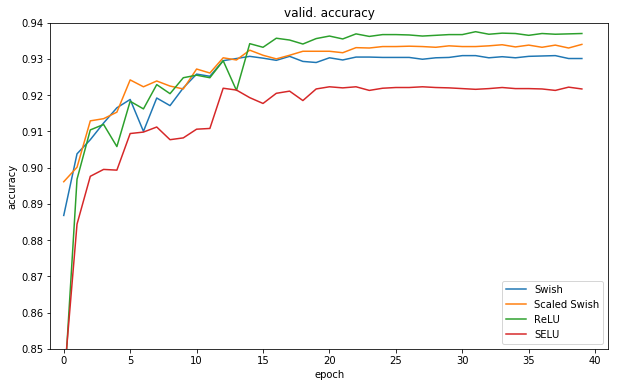

In [51]:
plot_history(hists, attribute='val_acc', loc='lower right')

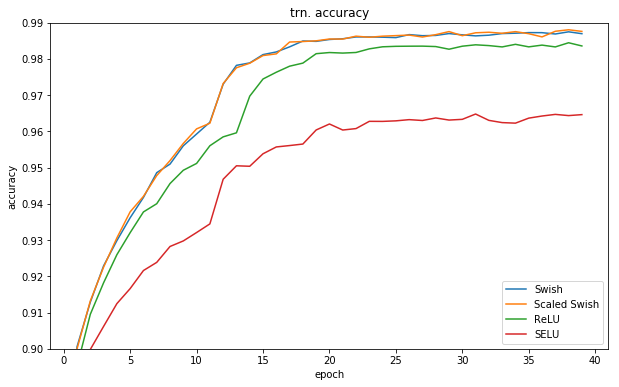

In [50]:
plot_history(hists, attribute='acc', axis=(-1,41,0.9,0.99), loc='lower right')

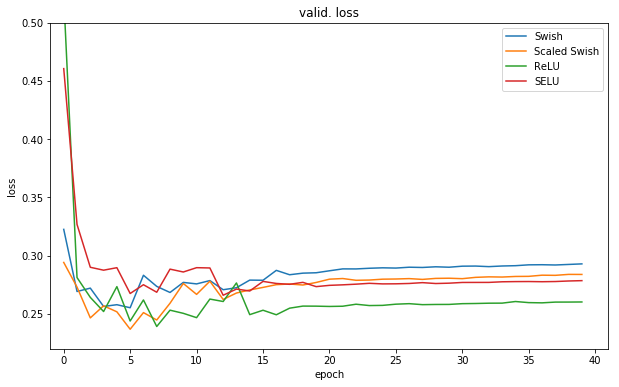

In [52]:
plot_history(hists, attribute='val_loss', axis=(-1,41,0.22,0.5), loc='upper right')

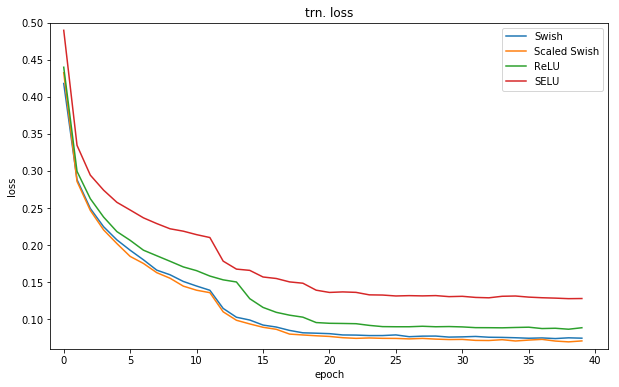

In [54]:
plot_history(hists, attribute='loss', axis=(-1,41,0.06,0.5), loc='upper right')

## Comparisons 2:

Optimizaer: SGD

Num of epochs: 40

In [62]:
hists_sgd = [hist_swish_sgd, hist_swish_rev_sgd, hist_relu_sgd]

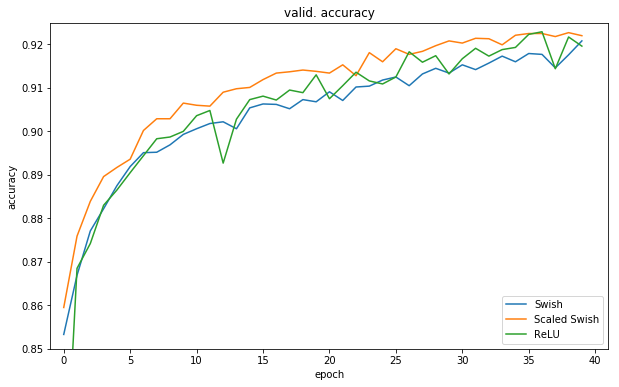

In [63]:
plot_history(hists_sgd, attribute='val_acc', axis=(-1,41,0.85,0.925), loc='lower right')

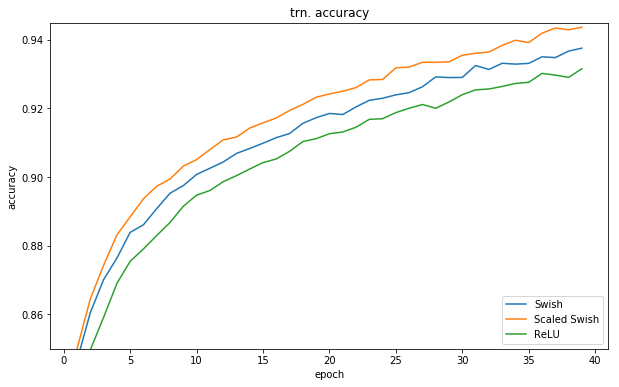

In [65]:
plot_history(hists_sgd, attribute='acc', axis=(-1,41,0.85,0.945), loc='lower right')

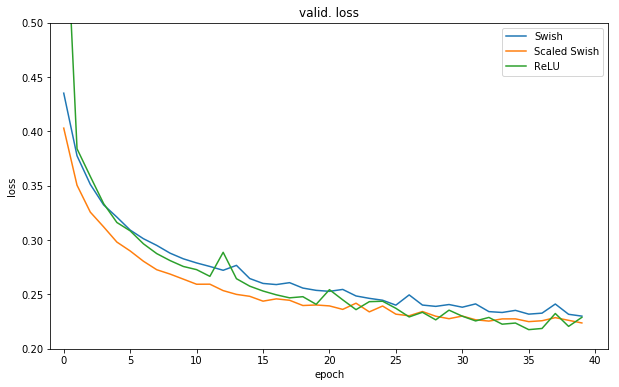

In [67]:
plot_history(hists_sgd, attribute='val_loss', axis=(-1,41,0.2,0.5), loc='upper right')

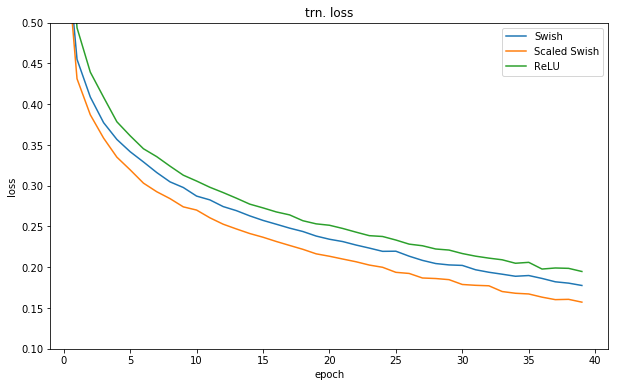

In [69]:
plot_history(hists_sgd, attribute='loss', axis=(-1,41,0.1,0.5), loc='upper right')

## Comparisons 3:

Optimizaer: SGD

Num of epochs: 100

In [18]:
hists_sgd = [hist_swish_sgd, hist_swish_rev_sgd, hist_relu_sgd]

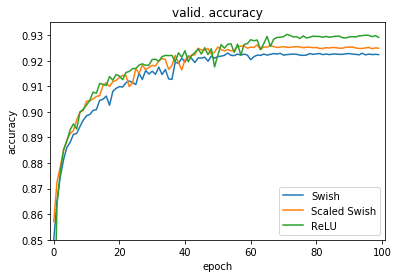

In [28]:
plot_history(hists_sgd, attribute='val_acc', axis=(-1,101,0.85,0.935), loc='lower right')

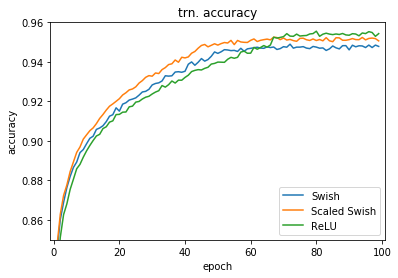

In [29]:
plot_history(hists_sgd, attribute='acc', axis=(-1,101,0.85,0.96), loc='lower right')

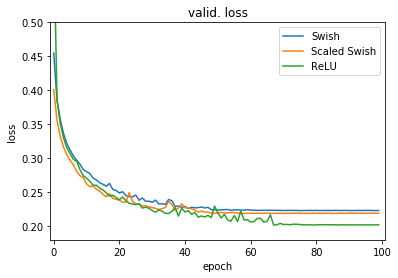

In [30]:
plot_history(hists_sgd, attribute='val_loss', axis=(-1,101,0.18,0.5), loc='upper right')

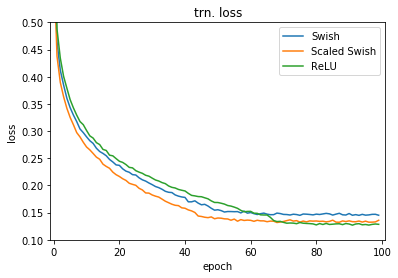

In [31]:
plot_history(hists_sgd, attribute='loss', axis=(-1,101,0.1,0.5), loc='upper right')